In [1]:
seed = 42

In [4]:
import torch
from nnfabrik.utility.nn_helpers import set_random_seed
set_random_seed(seed)

from sensorium.datasets.mouse_video_loaders import mouse_video_loader
from sensorium.utility.scores import get_correlations
from nnfabrik.builder import get_trainer
from sensorium.models.make_model import make_video_model

## Load Data

In [14]:
paths = [
    '''
    pathes to data folders like
    '/my_path/dynamic26872-19-13-Video-b580985c0d83307660a6109ec863aaed/',
    '/my_path/dynamic27204-3-13-Video-b580985c0d83307660a6109ec863aaed/',
    '''
]
print("Loading data..")
data_loaders = mouse_video_loader(
    paths=paths,
    batch_size=16,
    scale=1,
    max_frame=None,
    frames=50,
    offset=-1,
    include_behavior=True,
    include_pupil_centers=True,
    cuda='cuda:0',
)

Loading data..


## Example of model definition and training
### 2D core, GRU and Gaussian readout

This architecture is insipred by Sinz et all 2018 [1] and Willeke et all [2]. We take the general architecture concept from [1] : 2D convolutional core + GRU + readouts. The core is inspired by Willeke et all [2]. The modulator is not used because behavuoral activity is moved to the as additional channels but the shifter, which takes the pupil position, still stays, as it was at Willeke et all [2]. Sinz et all [1] used Factorised readouts, while we replace them with the Gaussian ones, introduced by Lurz et all [3].

This model trained jointly with behaviour is out first baseline.

----
[1] Sinz, F., Ecker, A. S., Fahey, P., Walker, E., Cobos, E., Froudarakis, E., ... & Tolias, A. (2018). Stimulus domain transfer in recurrent models for large scale cortical population prediction on video. Advances in neural information processing systems, 31.   

[2] Willeke, K. F., Fahey, P. G., Bashiri, M., Pede, L., Burg, M. F., Blessing, C., ... & Sinz, F. H. (2022). The Sensorium competition on predicting large-scale mouse primary visual cortex activity. arXiv preprint arXiv:2206.08666.   

[3] Lurz, K. K., Bashiri, M., Willeke, K., Jagadish, A. K., Wang, E., Walker, E. Y., ... & Sinz, F. H. (2020). Generalization in data-driven models of primary visual cortex. BioRxiv, 2020-10.

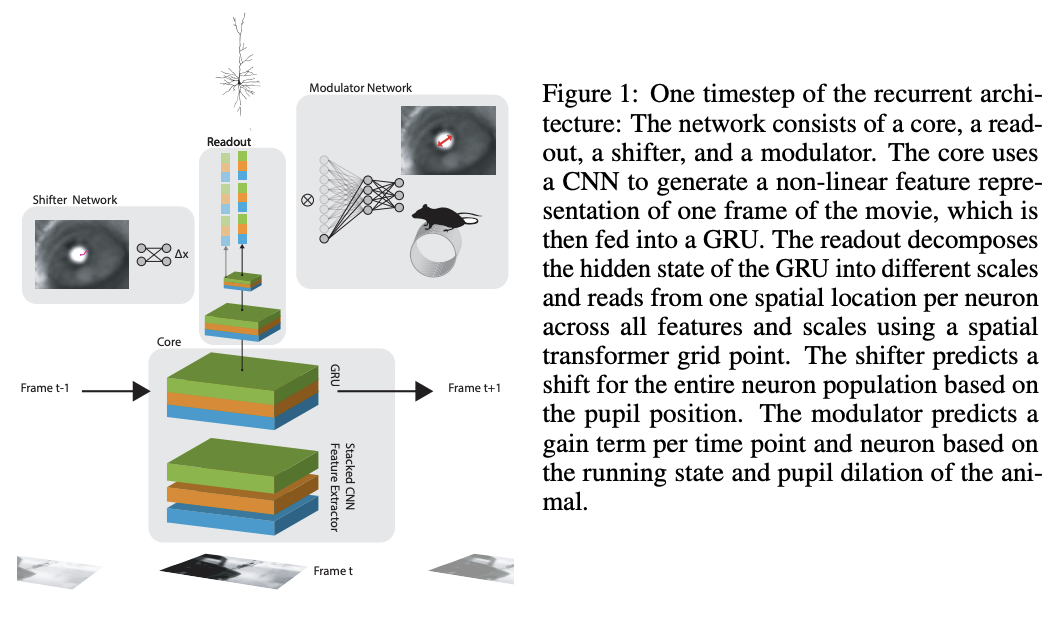
Figure 1 from Sinz et all, 2018 [1]

In [15]:
core_dict = dict(
    input_channels=3,
    hidden_channels=64,
    input_kern=9,
    hidden_kern=7,
    layers=4,
    gamma_input=500,
    skip=0,
    pad_input=False,
    final_nonlinearity=False,
    bias=True,
    momentum=0.9,
    batch_norm=True,
    hidden_dilation=1,
    laplace_padding=None,
    input_regularizer="LaplaceL2norm",
    stack=-1,
    depth_separable=False,
    linear=False,
    attention_conv=False,
    hidden_padding=None,
    use_avg_reg=False,
    final_batchnorm_scale=True,
    gamma_hidden=500_000,
)

In [16]:
gru_dict = dict(
    # input channels should be the last hidden channels from the core_dict
    input_channels=64,
    # rec channels should be the input channels to the readouts
    rec_channels=64,
    input_kern=7,
    rec_kern=7,
    gamma_rec=0,
)

shifter_dict = dict(
    gamma_shifter=0,
    shift_layers=3,
    input_channels_shifter=2,
    hidden_channels_shifter=5,
)


readout_dict = dict(
    bias=True,
    init_mu_range=0.2,
    init_sigma=1.0,
    gamma_readout=0.0,
    gauss_type='full',
    grid_mean_predictor={
        'type': 'cortex',
        'input_dimensions': 2,
        'hidden_layers': 1,
        'hidden_features': 30,
        'final_tanh': True
    },
    share_features=False,
    share_grid=False,
    shared_match_ids=None,
    gamma_grid_dispersion=0.0,
)


In [17]:
gru_2d_model = make_video_model(data_loaders,
                 seed,
                 core_dict=core_dict,
                 core_type='2D',
                 readout_dict=readout_dict.copy(),
                 readout_type='gaussian',               
                 use_gru=True,
                 gru_dict=gru_dict,
                 use_shifter=True,
                 shifter_dict=shifter_dict,
                 shifter_type='MLP',
                 # todo - put this to false if you use local dataset
                 # first connections to deeplake may take up for 10 mins
                 deeplake_ds=True,
                 )

In [18]:
gru_2d_model

VideoFiringRateEncoder(
  (core): Stacked2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(4, 64, kernel_size=(9, 9), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer1): Sequential(
        (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer2): Sequential(
        (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer3): Sequential(
        (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)

### Training

In [19]:
trainer_fn = "sensorium.training.video_training_loop.standard_trainer"

trainer_config = {
    'dataloaders' : data_loaders,
    'seed' : 111,
    'use_wandb' : False,
    'verbose': True,
    'lr_decay_steps': 4,
    'lr_init': 0.005,
    'device' : f"cuda:0",
    'detach_core' : False,
    # todo - put this to false if you use local dataset
    # first connections to deeplake may take up for 10 mins
    'deeplake_ds' : True,
                 }

trainer = get_trainer(trainer_fn=trainer_fn, 
                 trainer_config=trainer_config)

In [ ]:
#17 -10 
validation_score, trainer_output, state_dict = trainer(gru_2d_model)

### Testing

In [ ]:
val_correlation = get_correlations(
        enc, data_loaders["validation"], device=device, as_dict=False, per_neuron=False
    )

print(val_correlation)

## Other models example configs
### Rotation Equivariant 2D core, GRU and Gaussian readout

Here everything is the same except for the core. The core is rotation equivariant, inspired by Ecker et all 2018 [4]. Please note that the final amount of channels then is number_of_rotations * number_of_channels, as each channel is rotated number_of_rotations times.

---
[4] Ecker, A. S., Sinz, F. H., Froudarakis, E., Fahey, P. G., Cadena, S. A., Walker, E. Y., ... & Bethge, M. (2018). A rotation-equivariant convolutional neural network model of primary visual cortex. arXiv preprint arXiv:1809.10504.

In [16]:
equivar_2D_core_dict = dict(
    input_channels=3,
    hidden_channels=8,
    input_kern=9,
    hidden_kern=7,
    layers=4,
    num_rotations=8,
    gamma_input=500,
    skip=0,
    pad_input=False,
    final_nonlinearity=False,
    bias=True,
    momentum=0.9,
    batch_norm=True,
    hidden_dilation=1,
    laplace_padding=None,
    input_regularizer="LaplaceL2norm",
    stack=-1,
    depth_separable=False,
    linear=False,
    attention_conv=False,
    hidden_padding=None,
    use_avg_reg=False,
    final_batchnorm_scale=True,
    gamma_hidden=500_000,
)

In [ ]:
gru_2d_model_equivariant = make_video_model(data_loaders,
                 seed,
                 core_dict=equivar_2D_core_dict,
                 core_type='2D_equivariant',
                 readout_dict=readout_dict.copy(),
                 readout_type='gaussian',               
                 use_gru=True,
                 gru_dict=gru_dict,
                 use_shifter=True,
                 shifter_dict=shifter_dict,
                 shifter_type='MLP',
                 deeplake_ds=True,
                 )

In [18]:
gru_2d_model_equivariant

VideoFiringRateEncoder(
  (core): RotationEquivariant2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (hermite_conv): HermiteConv2D(
          (rotate_hermite): RotateHermite(
            (Rs): ParameterList(
                (0): Parameter containing: [torch.float32 of size 45x45]
                (1): Parameter containing: [torch.float32 of size 45x45]
                (2): Parameter containing: [torch.float32 of size 45x45]
                (3): Parameter containing: [torch.float32 of size 45x45]
                (4): Parameter containing: [torch.float32 of size 45x45]
                (5): Parameter containing: [torch.float32 of size 45x45]
                (6): Parameter containing: [torch.float32 of size 45x45]
                (7): Parameter containing: [torch.float32 of size 45x45]
            )
          )
        )
        (norm): RotationEquivariantBatchNorm2D(
          (batch_n

### Full 3D core and Gaussian readout

In [13]:
full_3D_core_dict = dict(
    input_channels=3,
    hidden_channels=[64]*2,
    input_kernel=9,
    hidden_kernel=7,
    num_frames=9,
    stride=1,
    layers=2,
    gamma_input_spatial=0,
    gamma_input_temporal=0,
    bias=True, 
    hidden_nonlinearities='elu',
    x_shift=0, 
    y_shift=0,
    batch_norm=True,
    laplace_padding=None,
    input_regularizer='LaplaceL2norm',
    padding=True,
    final_nonlin=True,
    independent_bn_bias=True,
    pad_time=False,
    momentum=0.7,
    spatial_input_kernel=None,
)

In [ ]:
full_3d_model = make_video_model(data_loaders,
                 seed,
                 core_dict=full_3D_core_dict,
                 core_type='3D',
                 readout_dict=readout_dict.copy(),
                 readout_type='gaussian',               
                 use_gru=False,
                 gru_dict=None,
                 use_shifter=True,
                 shifter_dict=shifter_dict,
                 shifter_type='MLP',
                 deeplake_ds=True,
                 )

In [15]:
full_3d_model

VideoFiringRateEncoder(
  (core): Basic3dCore(
    (_input_weight_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (temporal_regulazirer): TimeLaplaceL23d(
      (laplace): Laplace1d()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv3d(4, 64, kernel_size=(9, 9, 9), stride=(1, 1, 1), padding=(0, 4, 4))
        (norm): BatchNorm3d([64, 64], eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
      (layer1): Sequential(
        (conv_1): Conv3d(64, 64, kernel_size=(9, 7, 7), stride=(1, 1, 1), padding=(0, 3, 3))
        (norm): BatchNorm3d([64, 64], eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
    )
  ) [Basic3dCore regularizers: gamma_input_spatial = 0|gamma_input_temporal = 0]
  
  (readout): MultipleFullGaussian2d(
    (dynamic26872-19-13-Video-b580985c0d83307660a6109ec863aaed): full FullGaussian2d (64 x 22 x 50 -> 10968) wit

### Factorised 3D core and Gaussian readout

In [9]:
factorised_3D_core_dict = dict(
    input_channels=3,
    hidden_channels=[64]*3,
    spatial_input_kernel=(11,11),
    temporal_input_kernel=11,
    spatial_hidden_kernel=(7,7),
    temporal_hidden_kernel=7,
    stride=1,
    layers=3,
    gamma_input_spatial=0,
    gamma_input_temporal=0,
    bias=True, 
    hidden_nonlinearities='elu',
    x_shift=0, 
    y_shift=0,
    batch_norm=True,
    laplace_padding=None,
    input_regularizer='LaplaceL2norm',
    padding=True,
    final_nonlin=True,
    independent_bn_bias=True,
    pad_time=False,
    momentum=0.7
)

In [ ]:
factorised_3d_model = make_video_model(
    data_loaders,
    seed,
    core_dict=factorised_3D_core_dict,
    core_type='3D_factorised',
    readout_dict=readout_dict.copy(),
    readout_type='gaussian',               
    use_gru=False,
    gru_dict=None,
    use_shifter=True,
    shifter_dict=shifter_dict,
    shifter_type='MLP',
    deeplake_ds=True,
)

In [14]:
factorised_3d_model

VideoFiringRateEncoder(
  (core): Factorized3dCore(
    (_input_weight_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (temporal_regularizer): TimeLaplaceL23d(
      (laplace): Laplace1d()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv_spatial): Conv3d(4, 64, kernel_size=(1, 11, 11), stride=(1, 1, 1), padding=(0, 5, 5))
        (conv_temporal): Conv3d(64, 64, kernel_size=(11, 1, 1), stride=(1, 1, 1))
        (norm): BatchNorm3d(64, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
      (layer1): Sequential(
        (conv_spatial_1): Conv3d(64, 64, kernel_size=(1, 7, 7), stride=(1, 1, 1), padding=(0, 3, 3))
        (conv_temporal_1): Conv3d(64, 64, kernel_size=(7, 1, 1), stride=(1, 1, 1))
        (norm): BatchNorm3d(64, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
      (layer2): Sequential(
        (conv_spatial_2): Conv3d(64

### Factorised 3D core and Factorised readouts 

In [7]:
factorised_readout_dict = dict(
    bias=True,
    gamma_readout=0.0,
    spatial_and_feature_reg_weight=0.0,
    positive_weights=False,
    normalize=False,
    init_noise=0.001,
)

In [ ]:
factorised_3d_core_factorised_readout = make_video_model(
    data_loaders,
    seed,
    core_dict=factorised_3D_core_dict,
    core_type='3D_factorised',
    readout_dict=factorised_readout_dict,
    readout_type='factorised',               
    use_gru=False,
    gru_dict=None,
    use_shifter=True,
    shifter_dict=shifter_dict,
    shifter_type='MLP',
    deeplake_ds=True,
)

In [11]:
factorised_3d_core_factorised_readout

VideoFiringRateEncoder(
  (core): Factorized3dCore(
    (_input_weight_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (temporal_regularizer): TimeLaplaceL23d(
      (laplace): Laplace1d()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv_spatial): Conv3d(4, 64, kernel_size=(1, 11, 11), stride=(1, 1, 1), padding=(0, 5, 5))
        (conv_temporal): Conv3d(64, 64, kernel_size=(11, 1, 1), stride=(1, 1, 1))
        (norm): BatchNorm3d(64, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
      (layer1): Sequential(
        (conv_spatial_1): Conv3d(64, 64, kernel_size=(1, 7, 7), stride=(1, 1, 1), padding=(0, 3, 3))
        (conv_temporal_1): Conv3d(64, 64, kernel_size=(7, 1, 1), stride=(1, 1, 1))
        (norm): BatchNorm3d(64, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
      (layer2): Sequential(
        (conv_spatial_2): Conv3d(64